## Импорт библиотек
Импортируем необходимые библиотеки:

In [54]:
#import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import cascaded_union


from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.metrics import mean_absolute_error, make_scorer, f1_score

Путь к данным:

In [2]:
DATA_PATH = './datasets/'
SERV_RADIUS = 1000 #метров до поликлинники по СП 42.13330.2016

## Загрузим датасеты.

### Location
**01_Location_July.csv** и **01_CLocation_July.csv** - Сгенерированный датасет о численности населения на территории Москвы и с гранулярностью по районам города Москвы и секторами 500х500 метров.

***Характер данных***: Данные об изменении численности населения на территории

***Временное разбиение***: календарный месяц

***Территориальное разбиение***: Москва, разбитая по административным районам и на сектора 500х500м.

***Перечень показателей данных в данных:***
- Количество человек, проживающих на территории района/сектора
- Количество человек, работающих на территории района/сектора
- Количество человек, которые находились на территории района/сектора по будням в дневное время чаще, чем в любых других районах/секторах, в рассматриваемый месяц
- Количество человек, проживающих на территории района/сектора и имеющих разъездную работу

In [3]:
df_loc = pd.read_csv(DATA_PATH + '01_Location_July.csv')
print(df_loc.shape)
df_loc.head(3)

(146, 5)


,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
0,1,31723,11029,23944,1411
1,2,64780,15890,40845,3536
2,3,69098,39701,63486,4161


In [4]:
df_cloc = pd.read_csv(DATA_PATH + '01_CLocation_July.csv')
print(df_cloc.shape)
df_cloc.head(3)

(10240, 5)


,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
0,32909,4,0,0,0
1,32910,25,8,26,0
2,33261,2,0,2,0


### Matrix_Home_Work

**04_Matrix_Home_Work_July**; **04_CMatrix_Home_Work_July.csv** - Сгенерированный датасет о динамике перемещения населения дом-работа на территории Москвы (Матрица корреспонденции дом-работа) и с гранулярностью по районам города Москвы и секторами 500х500 метров.

***Характер данных***: Данные Матрица корреспонденции дом-работа

***Временное разбиение***: календарный месяц

***Территориальное разбиение***: Москва, разбитая по административным районам и на сектора 500х500м.

***Перечень показателей данных в данных:***

- Количество человек, место проживания которых в отчетном месяце находится в районе/секторе А, а место работы - в районе/секторе В

In [5]:
df_home_work = pd.read_csv(DATA_PATH + '04_Matrix_Home_Work_July.csv')
df_chome_work = pd.read_csv(DATA_PATH + '04_CMatrix_Home_Work_July.csv')
df_chome_work.head(1)

,home_zid,work_zid,customers_cnt
0,-2,33620,2


## Административное деление районов

Загрузим так же справочник соотношения секторов 500х500м и административного деления районов Москвы

In [6]:
df_sector_rel = pd.read_csv(DATA_PATH + 'relations_between_500x500_and_MSC.csv')
df_sector_rel.head(3)

,cell_zid,area_peresechenia_s_admzone_kv.km,adm_zid,adm_name,okrug_name,sub_ter
0,32909,0.407116,216,Роговское,Троицкий административный округ,Новая Москва
1,32910,1.003458,216,Роговское,Троицкий административный округ,Новая Москва
2,33261,0.233312,216,Роговское,Троицкий административный округ,Новая Москва


In [7]:
df_sector_rel['sub_ter'].value_counts()

Новая Москва     6734
Старая Москва    6498
Name: sub_ter, dtype: int64

In [8]:
new_zid_list = df_sector_rel.query('sub_ter == "Новая Москва"')['cell_zid'].to_list()

## Загрузим геоданные

In [9]:
shp_admzones = gpd.read_file(DATA_PATH + 'admzones2021/admzones2021.shp').to_crs(epsg=32637)
shp_fishnet = gpd.read_file(DATA_PATH + 'fishnet2021/fishnet2021.shp').to_crs(epsg=32637)

In [10]:
shp_admzones.head(2)

,adm_zid,adm_name,okrug_name,sub_ter,okrug_id,area,geometry
0,519,Коломна,None,Московская область,NaN,1.728866e+09,"POLYGON ((455694.923 6079507.744, 455694.900 6..."
1,507,Дзержинский,None,Московская область,NaN,1.566430e+07,"POLYGON ((424049.408 6164789.852, 424184.970 6..."


Оставим только данные, относящиеся к Москве:

In [11]:
shp_moscow = shp_admzones[(shp_admzones['sub_ter'] == 'Старая Москва') |\
                          (shp_admzones['sub_ter'] == 'Новая Москва')]

shp_mosnet = shp_fishnet.sjoin(shp_moscow, how="inner", predicate='intersects')

In [12]:
#ax = shp_admzones.plot(figsize=(17,17), alpha=0.5)
df_cloc
pd.merge(
    shp_admzones,
    df_sector_rel[['cell_zid', 'adm_zid']],
    how="inner",
    on='adm_zid',
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None).head(2)
#).plot(figsize=(17,17), color='red', alpha=0.01)

#plt.show()

,adm_zid,adm_name,okrug_name,sub_ter,okrug_id,area,geometry,cell_zid
0,109,Перово,Восточный административный округ,Старая Москва,561.0,9.829908e+06,"POLYGON ((421956.761 6180023.056, 422428.189 6...",107514
1,109,Перово,Восточный административный округ,Старая Москва,561.0,9.829908e+06,"POLYGON ((421956.761 6180023.056, 422428.189 6...",107515


In [13]:
import json
def coords(row):
    data = row['geodata_center']
    coord = json.loads(data)['coordinates']
    type_ = json.loads(data)['type']
    return coord, type_

In [14]:
#df_culture['geodata_center'][0]
#json.loads(df_culture['geodata_center'][0])['type']

In [15]:
#df_culture[['coordinates', 'type']] = df_culture.apply(coords, axis=1, result_type='expand')

## Загрузим наборы данных с data.mos.ru

Загрузим наборы данных с `data.mos.ru`, а именно:

1. [Поликлиническая помощь взрослым](https://data.mos.ru/opendata/503/)
1. [Поликлиническая помощь детям](https://data.mos.ru/opendata/505/)
1. [Границы зон охраны объектов культурного наследия](https://data.mos.ru/opendata/613/)
1. [Парковые территории](https://data.mos.ru/opendata/1465)

In [16]:
df_adult = pd.read_json(DATA_PATH + 'mos_ru/503_clinic_adult.json', encoding='windows-1251')
df_child = pd.read_json(DATA_PATH + 'mos_ru/505_clinic_child.json', encoding='windows-1251')

df_zculture = pd.read_json(DATA_PATH + 'mos_ru/613_zones_culture.json', encoding='windows-1251')
df_zpark = pd.read_json(DATA_PATH + 'mos_ru/1465_zones_park.json', encoding='windows-1251')

Функция для выделения координаты из данных:

In [17]:
def coords(row):
    data = row['geoData']
    if data['type'] == 'MultiPoint':
        return Point(data['coordinates'][0][0], data['coordinates'][0][1])
    elif data['type'] == 'MultiPolygon':
        try:
            return MultiPolygon(data['coordinates'][0])
        except:
            return Polygon(data['coordinates'][0][0])
    else:
        return Polygon(data['coordinates'][0])

In [18]:
def test(row):
    return row['geoData']['type']
    
df_zpark['test'] = df_zpark.apply(test, axis=1)

In [19]:
#df_adult[['longitude', 'latitude']] = df_adult.apply(coords, axis=1, result_type='expand')
df_adult['geometry'] = df_adult.apply(coords, axis=1)
df_child['geometry'] = df_child.apply(coords, axis=1)
df_zculture['geometry'] = df_zculture.apply(coords, axis=1)
df_zpark['geometry'] = df_zpark.apply(coords, axis=1)

Объединим объекты одного типа в общие DataFrame (клиники к клиникам, запретные зоны к запретным зонам)

In [20]:
df_adult['age'] = 'adult'
df_child['age'] = 'child'
df_zculture['zone_type'] = 'culture'
df_zculture['name'] = df_zculture['ObjectNameOnDoc']
df_zpark['zone_type'] = 'park'
df_zpark['name'] = df_zpark['CommonName']


df_clinic = pd.concat((df_adult, df_child))[['ShortName', 'age', 'geometry']]
df_zones = pd.concat((df_zculture, df_zpark))[['name', 'geometry']]

Создадим объекты типа **GeoDataFrame**

In [21]:
gdf_clinic = gpd.GeoDataFrame(
    df_clinic, geometry=df_clinic.geometry,
    crs="EPSG:4326").to_crs(epsg=32637)

gdf_zones = gpd.GeoDataFrame(
    df_zones, geometry=df_zones.geometry,
    crs="EPSG:4326").to_crs(epsg=32637)

Добавим буфера - зоны диаметром в зону обслуживания поликлинники в соответствии с *СП 42.13330.2016 "Градостроительство. Планировка и застройка городских и сельских поселений"*

In [22]:
gdf_clinic_buff = gdf_clinic.copy()

gdf_clinic_buff.geometry = gpd.GeoSeries(cascaded_union(gdf_clinic_buff.geometry.buffer(SERV_RADIUS)))

## Анализ

Приступим к анализу полученных данных, для начала объединим данные по численности населения с картой Москвы:

In [23]:
gdf_cloc = pd.merge(shp_mosnet,
                    df_cloc,
                    how="inner",
                    left_on='cell_zid',
                    right_on='zid',
                    sort=False,
                    suffixes=("_x", "_y"),
                    copy=True,
                    indicator=False,
                    validate=None).drop(columns='zid')

In [24]:
gdf_cloc.head(2)

,cell_zid,geometry,index_right,adm_zid,adm_name,okrug_name,sub_ter,okrug_id,area,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
0,32909,"POLYGON ((374654.459 6112167.888, 374665.200 6...",60,216,Роговское,Троицкий административный округ,Новая Москва,572.0,1.782183e+08,4,0,0,0
1,32910,"POLYGON ((375154.304 6112157.147, 375165.045 6...",60,216,Роговское,Троицкий административный округ,Новая Москва,572.0,1.782183e+08,25,8,26,0


In [25]:
#gdf_cloc.explore(
#    column="served", # make choropleth based on "BoroName" column
#    tooltip="served", # show "BoroName" value in tooltip (on hover)
#    popup=True, # show all values in popup (on click)
#    tiles="CartoDB positron", # use "CartoDB positron" tiles
#    cmap="Set1", # use "Set1" matplotlib colormap 
#   )

Добавим все сектора, обслуживаемые хоть одной поликлинникой

In [26]:
# Если подобную зону надо отрисовать отдельно:
#gdf_served = gpd.overlay(gdf_cloc, gdf_clinic_buff, how='intersection')[['cell_zid', 'geometry']]

served_list = gpd.overlay(gdf_cloc, gdf_clinic_buff, how='intersection')['cell_zid'].unique()

gdf_cloc['served'] = np.where(gdf_cloc['cell_zid'].isin(served_list), 1, 0)

Также добавим все сектора, в которых строить нежелательно (парки, зоны культурного наследия)

In [27]:
stop_list = gpd.overlay(gdf_cloc, gdf_zones, how='intersection')['cell_zid'].unique()

gdf_cloc['blocked'] = np.where(gdf_cloc['cell_zid'].isin(stop_list), 1, 0)

<AxesSubplot:>

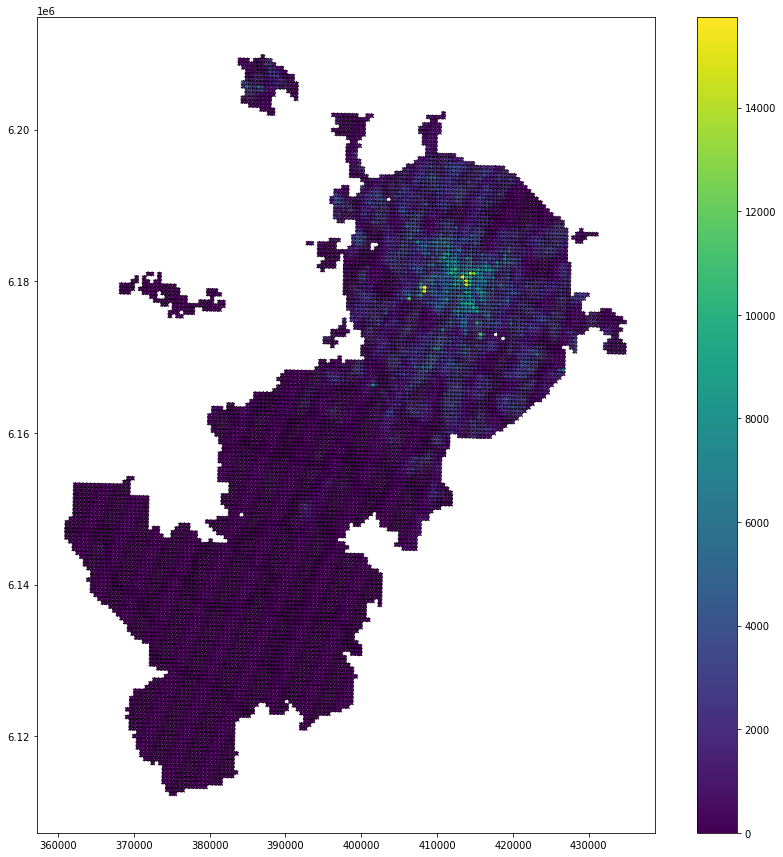

In [231]:
gdf_cloc.plot(figsize=(15,15),
                        linestyle=':',
                        edgecolor='black',
                        column='customers_cnt_day',
                        legend=True)

<AxesSubplot:>

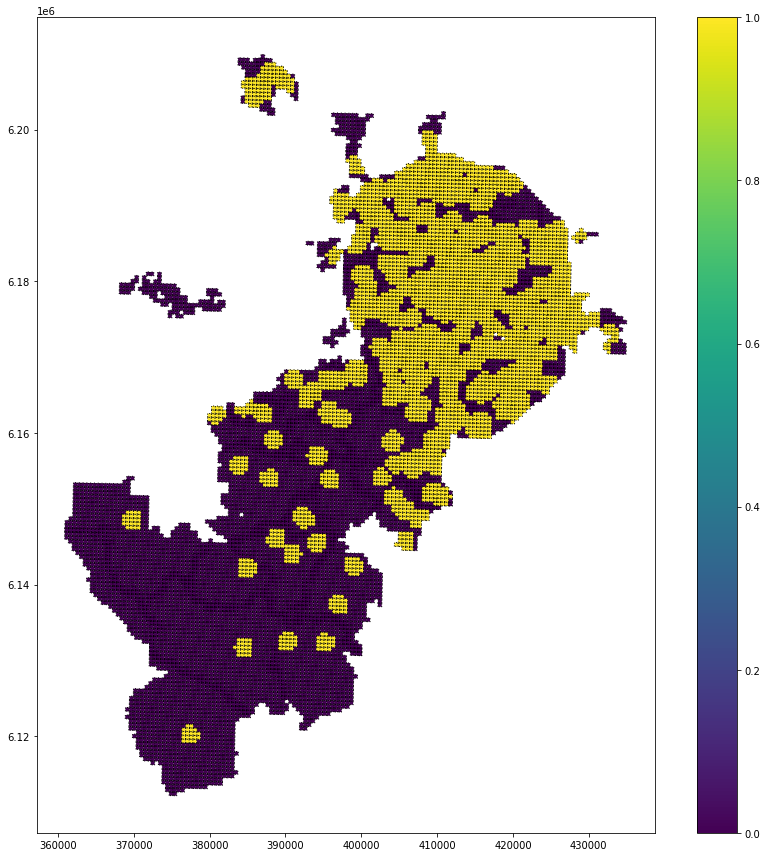

In [29]:
gdf_cloc.plot(figsize=(15,15),
                        linestyle=':',
                        edgecolor='black',
                        column='served',
                        legend=True)

## Моделирование

Подготовим наши признаки:

In [30]:
gdf_cloc.cell_zid.value_counts()

114417    5
107516    5
120384    4
118811    4
100382    4
         ..
74965     1
74966     1
74967     1
74968     1
138916    1
Name: cell_zid, Length: 10240, dtype: int64

In [145]:
data = gdf_cloc[['cell_zid',
                 'sub_ter',
                 'customers_cnt_home',
                 'customers_cnt_job',
                 'customers_cnt_day',
                 'customers_cnt_move',
                 'served']].drop_duplicates().copy().set_index('cell_zid')
#                 'served',
#                 'blocked']].drop_duplicates().copy().set_index('cell_zid')

data = data[~data.index.duplicated(keep='first')]

In [146]:
data

,sub_ter,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move,served
cell_zid,,,,,,
32909,Новая Москва,4,0,0,0,0
32910,Новая Москва,25,8,26,0,0
33261,Новая Москва,2,0,2,0,0
33262,Новая Москва,13,2,11,0,0
33263,Новая Москва,10,0,3,0,0
...,...,...,...,...,...,...
138487,Старая Москва,115,504,566,4,0
138488,Старая Москва,1202,1819,2347,36,1
138489,Старая Москва,1899,1093,1908,77,1


In [147]:
train = data.loc[data['sub_ter'] == 'Старая Москва'].drop('sub_ter', axis=1).copy()
test = data.loc[data['sub_ter'] == 'Новая Москва'].drop('sub_ter', axis=1).copy()

In [148]:
train.served.value_counts()

1    3279
0    1101
Name: served, dtype: int64

In [149]:
test.served.value_counts()

0    5099
1     761
Name: served, dtype: int64

In [150]:
X_train = train.copy()
X_test = test.copy()

y_train = X_train.pop('served')
y_test = X_test.pop('served')

In [151]:
model = DummyClassifier(strategy='uniform')

model.fit(X_train, y_train)

preds = pd.Series(model.predict(X_test), index=X_test.index)

f1_score(y_test, preds)

0.20928990923651897

In [152]:
model = LogisticRegression()

model.fit(X_train, y_train)

preds = pd.Series(model.predict(X_test), index=X_test.index)

f1_score(y_test, preds)

0.36678832116788324

In [159]:
model = DecisionTreeClassifier()

model.fit(X_train, y_train)

preds = pd.Series(model.predict(X_test), index=X_test.index)

f1_score(y_test, preds)

0.39321511179645335

In [202]:
model = RandomForestClassifier(n_estimators=71,
                               max_depth=8,
                               n_jobs=-1,
                               random_state=13)

model.fit(X_train, y_train)

preds = pd.Series(model.predict(X_test), index=X_test.index, name='served')

f1_score(y_test, preds)

0.4

In [203]:
preds

cell_zid
32909    0
32910    0
33261    0
33262    0
33263    0
        ..
93248    1
93249    1
93250    1
93842    1
93843    1
Name: served, Length: 5860, dtype: int32

<AxesSubplot:>

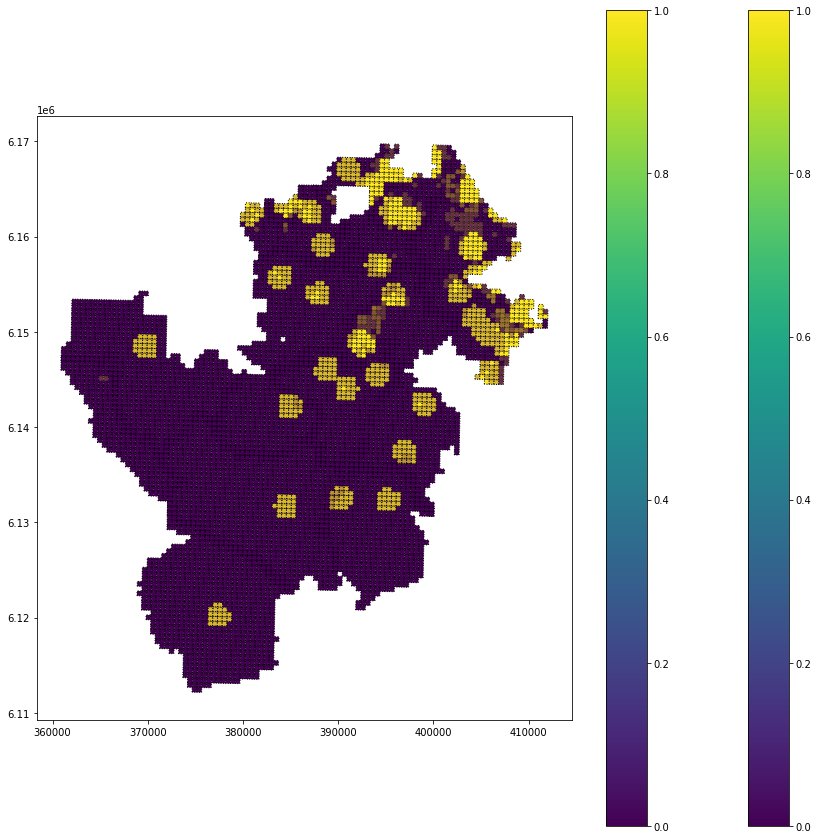

In [204]:
ax = pd.merge(
    gdf_cloc[gdf_cloc['sub_ter']=='Новая Москва'],
    preds,
    how="inner",
    on='cell_zid').plot(figsize=(15,15),
                        linestyle=':',
                        edgecolor='black',
                        column='served_x',
                        legend=True)

pd.merge(
    gdf_cloc[gdf_cloc['sub_ter']=='Новая Москва'],
    preds,
    how="inner",
    on='cell_zid').plot(figsize=(15,15),
                        linestyle=':',
                        edgecolor='black',
                        column='served_y',
                        alpha=0.2,
                        legend=True, ax=ax)

In [216]:
df_zero = pd.read_csv(DATA_PATH + 'extracted_points.csv')
print(df_zero.shape)

(305, 2)


In [219]:
df_zero

,X,Y
0,55.630735,37.454585
1,55.621276,37.463908
2,55.610820,37.466784
3,55.604532,37.475684
4,55.592876,37.451752
...,...,...
300,55.619948,37.285614
301,55.624688,37.260697
302,55.625658,37.298130
303,55.625511,37.308434


In [225]:
gdf_zero = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(df_zero['Y'], df_zero['X'], crs="EPSG:4326")).to_crs(epsg=32637)

<AxesSubplot:>

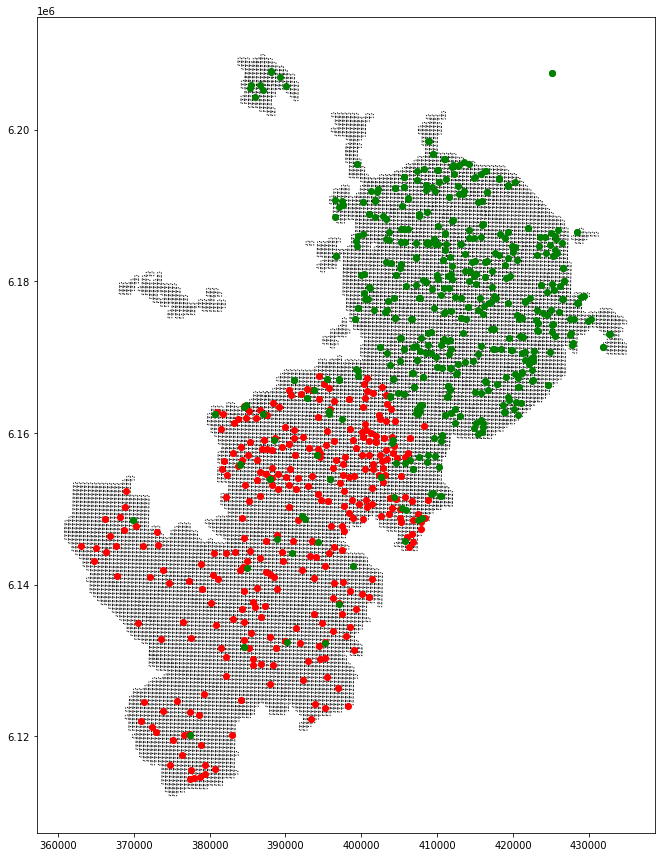

In [233]:
ax = gdf_cloc.plot(figsize=(15,15),
                   linestyle=':',
                   color='whitesmoke',
                   edgecolor='black',
                   legend=True)

gdf_zero.plot(ax=ax, color='red')
gdf_clinic.plot(ax=ax, color='green')